In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# Decision trees
### CART (Classification And Regression Trees)

![titanic](https://cdn.patricktriest.com/blog/images/posts/titanic-ml/decision-tree.png)

They look for the variable and threshold value that best partitions the dataset, then do that recursively.

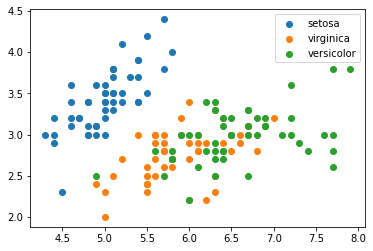

In [2]:
from sklearn.datasets import load_iris

x, y = load_iris(return_X_y=True, as_frame=True)

plt.scatter(x.iloc[:, 0][y == 0], x.iloc[:, 1][y == 0])
plt.scatter(x.iloc[:, 0][y == 1], x.iloc[:, 1][y == 1])
plt.scatter(x.iloc[:, 0][y == 2], x.iloc[:, 1][y == 2])

plt.legend(['setosa', 'virginica', 'versicolor'])

plt.show()

In [3]:
class DecisionTree():
    def __init__(self):
        self.x = None
        self.y = None
        self.tree = {}
    
    def gini(self, group):
        gini = 0
        
        # Avoid computing Gini on empty groups.
        if not len(group):
            return gini
        
        # Gini index.
        for k in range(self.y.nunique()):
            p = (self.y[group.index] == k).mean() # Propotion of cases with label k.
            gini += p * (1 - p)
        return gini
    
    def split(self, group, column, threshold):
        idx = group[column] < threshold
        left, right = group[idx], group[~idx]
        return left, right
    
    def best_split(self, group):
        best_gini = 1
        best_column = None
        best_threshold = None
        
        for column in group.columns:
            for row in group.index:
                threshold = group.loc[row, column] # Easy to implement, but inefficient.
                left, right = self.split(group, column, threshold)
                
                gini = (self.gini(left) * len(left) \
                      + self.gini(right) * len(right)) \
                      / len(group) # Scale Gini by group size.
                
                if gini < best_gini:
                    best_gini = gini
                    best_column = column
                    best_threshold = threshold
                    
        return best_gini, best_column, best_threshold
        
    def build_node(self, group, min_cases=1):
        '''Depth-first recursive building'''
        classes = self.y[group.index].unique()
        if len(classes) == 1:
            subtree = classes
        else:
            g, c, t = self.best_split(group)
            left, right = self.split(group, c, t)
        
            subtree = {}
            subtree['rule'] = (g, c, t)
            #subtree['data'] = group # Convenient, but inefficient.
            
            subtree['left'] = self.build_node(left)
            subtree['right'] = self.build_node(right)
            
            # Stop early if the minimum size is reached.
            #if len(left) >= min_cases:
            #    subtree['left'] = self.build_node(left, min_cases)
            #else:
            #    subtree['left'] = self.y[left.index].unique()   
            #if len(right) >= min_cases:
            #    subtree['right'] = self.build_node(right, min_cases)
            #else:
            #    subtree['right'] = self.y[right.index].unique()
                
        return subtree
    
    def fit(self, x, y, min_cases=1):
        assert len(x) == len(y)
        self.x = x
        self.y = y
        self.tree = self.build_node(self.x)
        
    def traverse(self, subtree, x):
        '''Depth-first recursive traversal'''
        if type(subtree) is dict:
            assert 'rule' in subtree
            _, column, threshold = subtree['rule']
            if x[column] < threshold:
                return self.traverse(subtree['left'], x)
            else:
                return self.traverse(subtree['right'], x)
        else:
            return subtree[0] # Be careful on leaves with mixed classes.
            
    def predict(self, x):
        assert self.tree, 'DecisionTree.fit() needs to be run first'
        
        predictions = pd.Series([np.nan] * len(x))
        for i in range(len(x)):
            predictions.iloc[i] = self.traverse(self.tree, x.iloc[i])
        
        predictions.index = x.index
        return predictions
    
    def accuracy(self, pred, y):
        return (pred == y).mean()
    
    
model = DecisionTree()
model.fit(x, y)

## Easy to explain (really?)

In [4]:
model.tree

{'rule': (0.3333333333333333, 'petal length (cm)', 3.0),
 'left': array([0]),
 'right': {'rule': (0.11030595813204506, 'petal width (cm)', 1.8),
  'left': {'rule': (0.08564814814814818, 'petal length (cm)', 5.0),
   'left': {'rule': (0.0, 'petal width (cm)', 1.7),
    'left': array([1]),
    'right': array([2])},
   'right': {'rule': (0.22222222222222224, 'petal width (cm)', 1.6),
    'left': array([2]),
    'right': {'rule': (0.0, 'sepal length (cm)', 7.2),
     'left': array([1]),
     'right': array([2])}}},
  'right': {'rule': (0.028985507246376815, 'petal length (cm)', 4.9),
   'left': {'rule': (0.0, 'sepal length (cm)', 6.0),
    'left': array([1]),
    'right': array([2])},
   'right': array([2])}}}

#### What happens when we have a dataset with 100 variables and 10 classes?

### Interpretability is a joint property of the dataset and the model.

## Performance on the train set

In [5]:
pred = model.predict(x)
pred

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
145    2.0
146    2.0
147    2.0
148    2.0
149    2.0
Length: 150, dtype: float64

In [6]:
model.accuracy(pred, y)

1.0

### By definition, a basic decision tree always gets 100% accuracy on the train set (always overfits).

## Comparison with sklearn

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y)

In [8]:
model = DecisionTree()
model.fit(x_train, y_train)
pred = model.predict(x_test)
acc = model.accuracy(pred, y_test)

acc

0.9473684210526315

In [9]:
from sklearn.tree import DecisionTreeClassifier

sk_model = DecisionTreeClassifier()
sk_model.fit(x_train, y_train)
sk_pred = sk_model.predict(x_test)
sk_acc = sk_model.score(x_test, y_test)

sk_acc

0.9736842105263158

In [10]:
# Our tree.
model.tree

{'rule': (0.31919642857142855, 'petal length (cm)', 3.3),
 'left': array([0]),
 'right': {'rule': (0.1048951048951049, 'petal length (cm)', 4.9),
  'left': {'rule': (0.04040404040404041, 'petal width (cm)', 1.7),
   'left': array([1]),
   'right': {'rule': (0.0, 'sepal width (cm)', 3.2),
    'left': array([2]),
    'right': array([1])}},
  'right': {'rule': (0.06837606837606838, 'petal length (cm)', 5.1),
   'left': {'rule': (0.22222222222222224, 'sepal length (cm)', 6.3),
    'left': array([2]),
    'right': {'rule': (0.0, 'petal width (cm)', 1.8),
     'left': array([1]),
     'right': array([2])}},
   'right': array([2])}}}

In [11]:
x.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

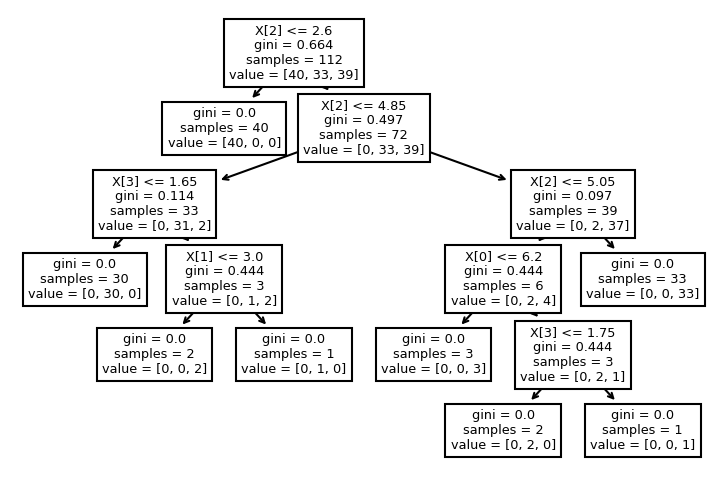

In [12]:
# sklearn's tree.
from sklearn.tree import plot_tree

plt.figure(dpi=150)
plot_tree(sk_model)

plt.show()

# Hyperparameter optimization by k-fold cross validation

In [13]:
from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import RandomizedSearchCV

# These are the 2 most common regularization hyperparameters.
max_depths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
min_samples_leafs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

estimator = DecisionTreeClassifier()
para_grid = param_grid = [{'max_depth': max_depths,
                           'min_samples_leaf': min_samples_leafs}]
cv_model = GridSearchCV(estimator, param_grid, cv=10) # 5-fold CV by default.
cv_model.fit(x, y) # It will do the split for us.

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}])

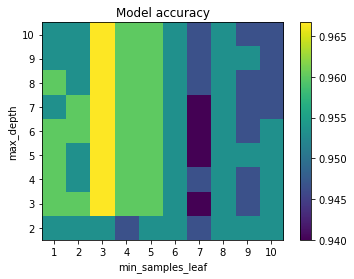

In [14]:
acc = cv_model.cv_results_['mean_test_score'] \
.reshape((len(max_depths), len(min_samples_leafs)))

plt.imshow(acc, origin='lower')
plt.xticks(range(len(min_samples_leafs)), min_samples_leafs)
plt.yticks(range(len(max_depths)), max_depths)

plt.title('Model accuracy')
plt.xlabel('min_samples_leaf')
plt.ylabel('max_depth')
plt.colorbar()

plt.show()

In [15]:
print(cv_model.best_params_)
print(cv_model.best_score_)

{'max_depth': 3, 'min_samples_leaf': 3}
0.9666666666666666
